In [90]:
using Gurobi, Cbc, Mosek, PyPlot, JuMP, Ipopt


## Tyre specs
coflo = 0.2 #coeffecient of friction longitudnal(in direction of motion)
cofla = 0.4 #coeffecient of friction lattitudnal(perpendicular to direction of motion of the front tyers when they turn)


## car specs all specs in meters and seconds
# mass = 1000 # in kg
g = 9.8  # gravitational pull in m/sec^2
maxacc = 6.5 # max acc in m/sec^2
maxv = 55.55 # max velocity in m/sec equivalent to 200km/hr
maxTu = 1.27 #max steer one side


##model
m = Model(solver = IpoptSolver(print_level=0))


## Start ad Finish constraints
k =22
startPos = [50,1]
finishPos = [50, 5000]
# finishPos = [25000,180000]
startVel = [0,10]
finishVel = [0,0]
finishAcc = [0,0]

## Basic variables and their constraints
@variable(m, P[1:2,1:k])  # resulting position in x,y
@variable(m, v[1:2,1:k])
@variable(m, 0 <= Thrust[1:k] <= maxacc)  # thruster input
@variable(m, 0 <= Braking[1:k] <= 2*maxacc)  # braking input
@variable(m, AccDM[1:2,1:k])
@variable(m, AccDMBeta[1:k] >= 0)
@variable(m, AccCent[1:2,1:k])
@constraint(m, P[:,1] .== startPos)
@constraint(m, v[:,1] .== startVel)
# @constraint(m, v[:,k] .== finishVel)
# @constraint(m, AccDM[:,k] .== finishAcc)
@NLexpression(m, finishDistance, sum((P[i,k]-finishPos[i])^2 for i in 1:2))


## motion constraints
for t in 1:k
    @NLconstraint(m, AccDM[1,t]*AccCent[1,t] + AccDM[2,t]*AccCent[2,t] == 0)
#     @NLconstraint(m, ((AccDM[1,t]^2)+(AccDM[2,t]^2)) == (Thrust[t] - Braking[t] - (coflo*g))^2)
    @NLconstraint(m, ((AccDM[1,t]^2)+(AccDM[2,t]^2)) == (Thrust[t] - Braking[t])^2)
    @NLconstraint(m, (AccCent[1,t]^2)+(AccCent[2,t]^2) <= (cofla*g)^2)
    @NLconstraint(m, (v[1,t]^2)+(v[2,t]^2) <= maxv^2)
end

for t in 1:k-1
    @constraint(m, AccDM[:,t] .== AccDMBeta[t]*(P[:,t+1]-P[:,t]))
    @constraint(m, v[1,t+1] == v[1,t] + AccDM[1,t] + AccCent[1,t])
    @constraint(m, v[2,t+1] == v[2,t] + AccDM[2,t] + AccCent[2,t])  
    @constraint(m, P[1,t+1] == P[1,t] + v[1,t] + (.5)*(AccDM[1,t] + AccCent[1,t])) 
    @constraint(m, P[2,t+1] == P[2,t] + v[2,t] + (.5)*(AccDM[2,t] + AccCent[2,t]))     
end


# for t in 2:k-2
#     @NLconstraint(m, (atan(v[2,t]/v[1,t])-atan(v[2,t+1]/v[1,t+1])) <= maxTu)
#     @NLconstraint(m, (atan(v[2,t]/v[1,t])-atan(v[2,t+1]/v[1,t+1])) >= -maxTu)
# end


## Track boundaries variables and constraints
@constraint(m, 0 .<= P[1,:] .<= 5000)
for t in 1:k
    @NLconstraint(m, P[2,t] <= 5000 + sqrt(2500^2 - P[1,t]^2))
    @NLconstraint(m, (P[1,t]-2500)^2 + (P[2,t]-5000)^2 >= 2400^2)
end


## Objective function
@NLobjective(m, Min, finishDistance)
solve(m)

:Error

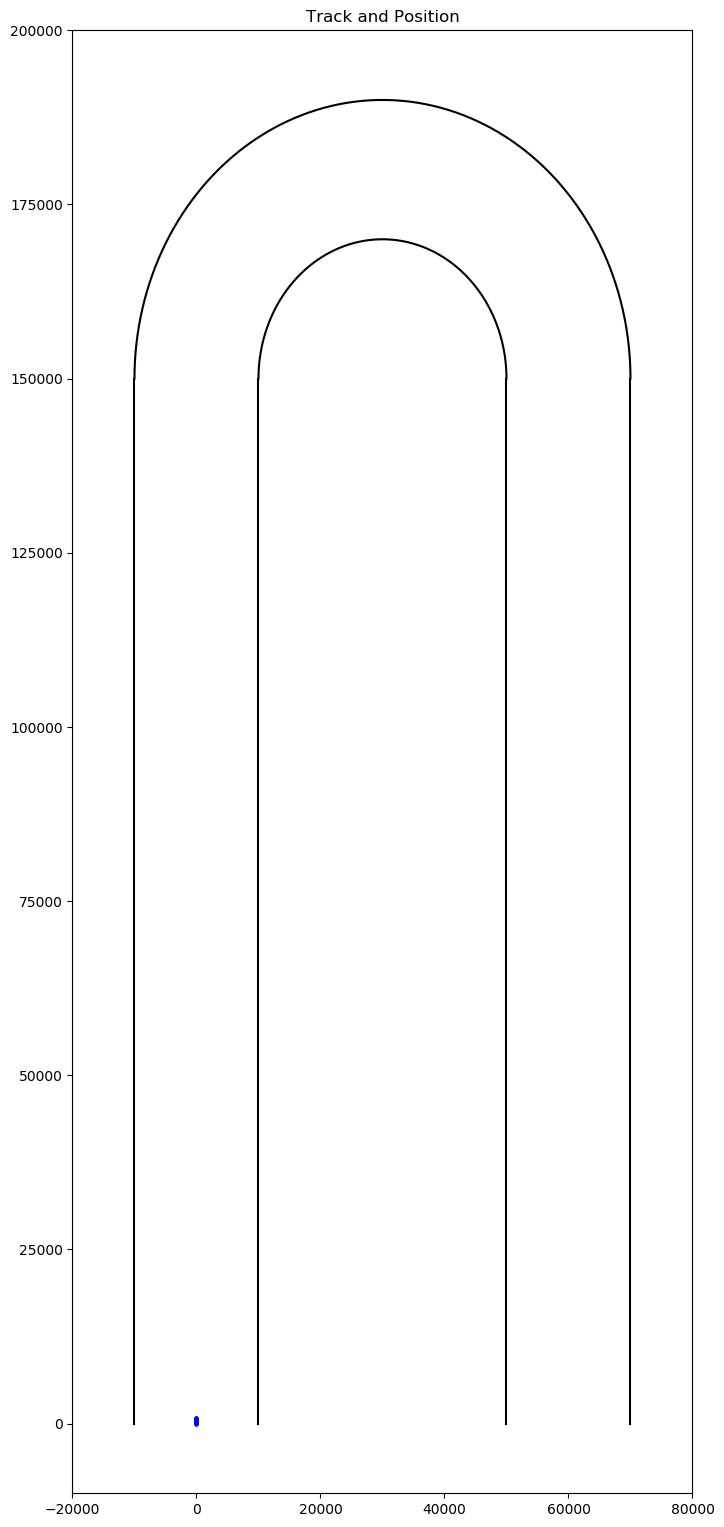

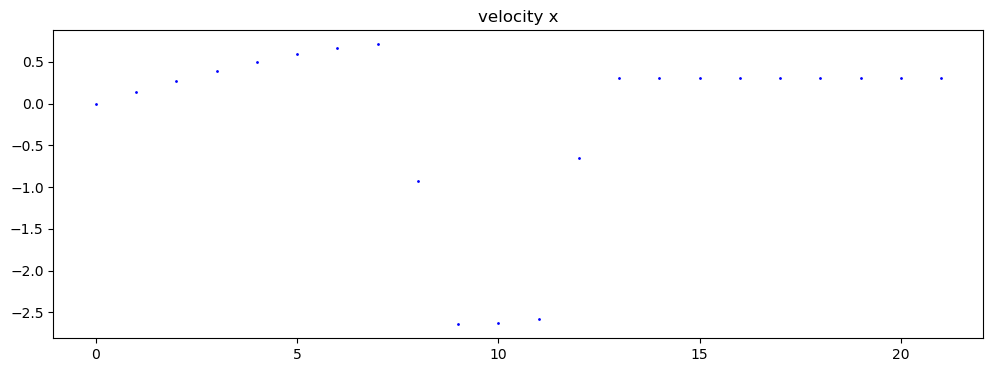

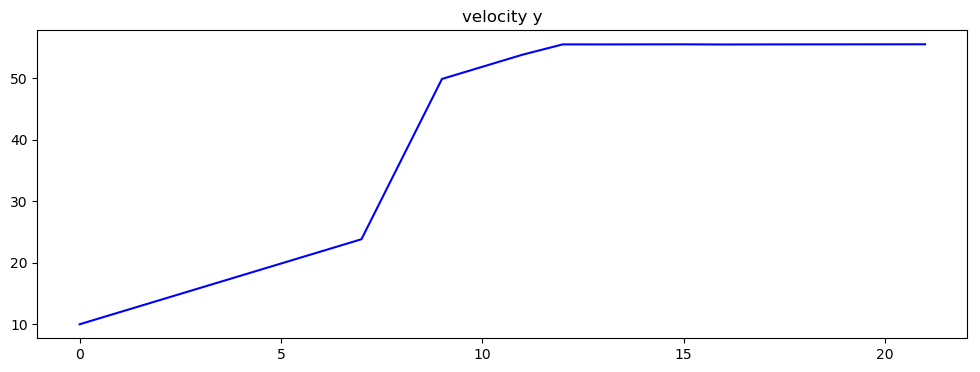

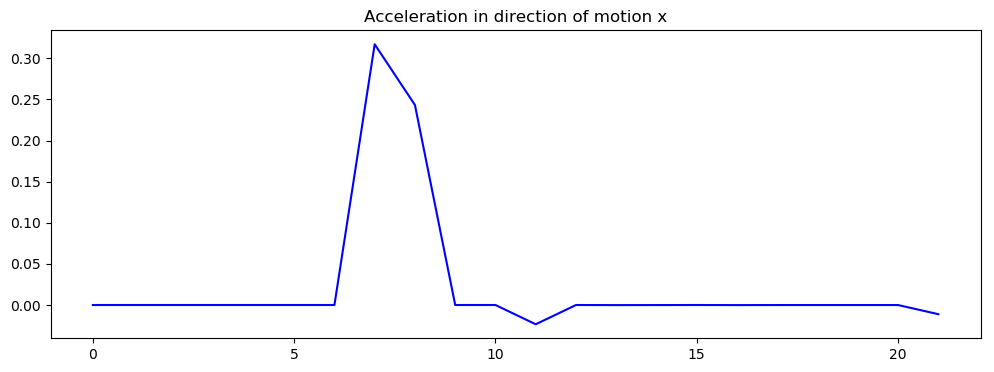

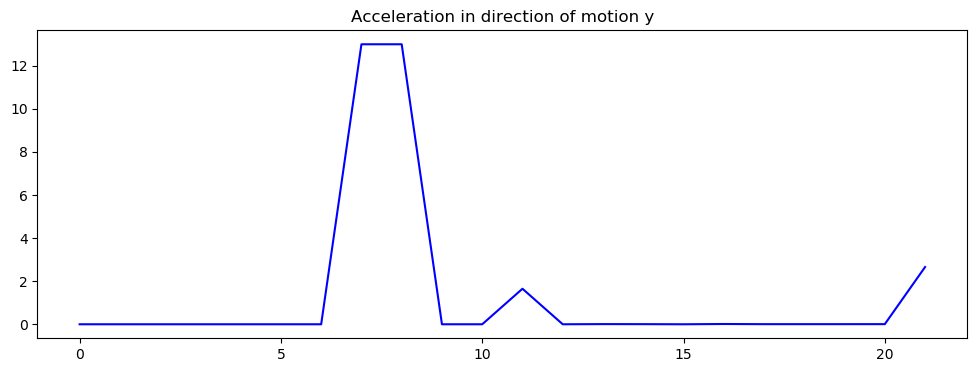

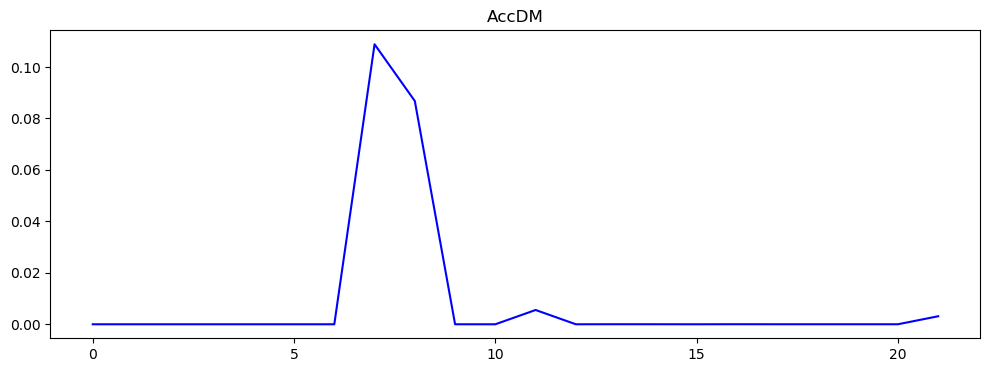

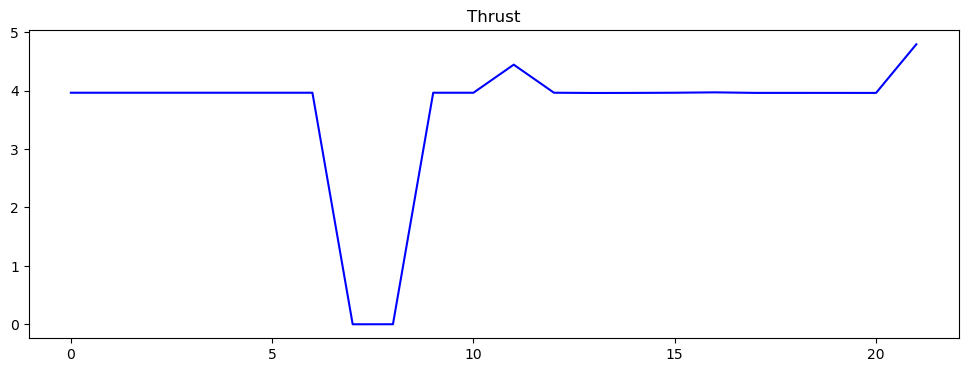

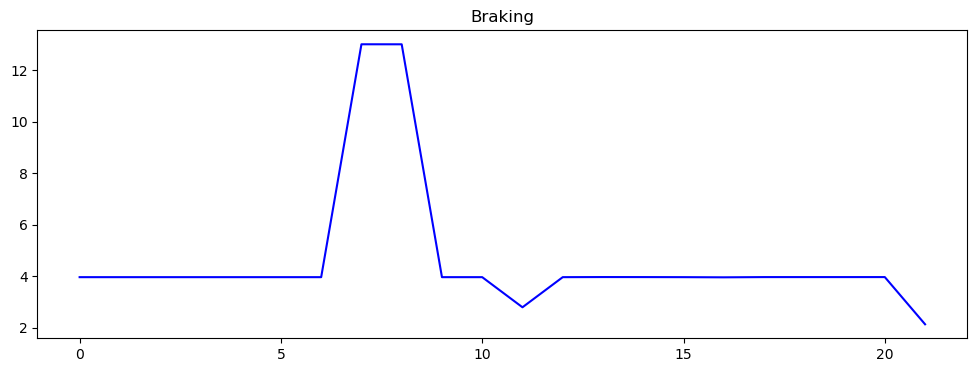

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1442df710>

In [91]:
## Plotting everything
#Plotting track (Position plots will also go in same figure)
rad = linspace(0,π,100) 
x = 30000 + 40000*cos.(rad)
y = 150000 +40000*sin.(rad)
x1 = 30000 + 20000*cos.(rad)
y1 = 150000 +20000*sin.(rad)
Llinex = [-10000, -10000]
Lliney = [0, 150000]
LMlinex = [10000,10000]
LMliney = [0,150000]
RMlinex = [50000, 50000]
RMliney = [0,150000]
Rlinex = [70000,70000]
Rliney = [0,150000]
figure(figsize=(8,19))
title("Track and Position")
#Track
plot(Llinex[:],Lliney[:], color = "#000000", markersize=4 )
plot(LMlinex[:],LMliney[:],color = "#000000", markersize=4 )
plot(RMlinex[:],RMliney[:], color = "#000000", markersize=4 )
plot(Rlinex[:],Rliney[:], color = "#000000", markersize=4 )
plot(x,y, color = "#000000", markersize=4 )
plot(x1,y1, color = "#000000", markersize=4 )
#Position
plot( getvalue(P[1,:]), getvalue(P[2,:]), "b.-", markersize=4 )
axis((-20000,80000,-10000,200000));

figure(figsize=(12,4))
title("velocity x")
plot( getvalue(v[1,:]), "b.", markersize=2 )

figure(figsize=(12,4))
title("velocity y")
plot( getvalue(v[2,:]), "b-", markersize=2 )

figure(figsize=(12,4))
title("Acceleration in direction of motion x")
plot( getvalue(AccDM[1,:]), "b-", markersize=2 )

figure(figsize=(12,4))
title("Acceleration in direction of motion y")
plot( getvalue(AccDM[2,:]), "b-", markersize=2 )

figure(figsize=(12,4))
title("AccDM")
plot( getvalue(AccDMBeta), "b-", markersize=2 )

figure(figsize=(12,4))
title("Thrust")
plot( getvalue(Thrust), "b-", markersize=2 )

figure(figsize=(12,4))
title("Braking")
plot( getvalue(Braking), "b-", markersize=2 )